In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%reload_ext snakeviz

from collections import namedtuple
from functools import partial, wraps

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable

from src.data_processing import (get_interpolated_position_dataframe,
                                 get_mark_indicator_dataframe,
                                 make_tetrode_dataframe, reshape_to_segments)
from src.ripple_detection import get_epoch_ripples
from src.ripple_decoding import (combined_likelihood,
                                 estimate_marked_encoding_model, get_ripple_info,
                                 joint_mark_intensity, poisson_mark_likelihood,
                                 predict_state, _compute_decision_state_probability,
                                 _get_bin_centers, estimate_state_transition,
                                 set_initial_conditions, evaluate_mark_space,
                                 empirical_movement_transition_matrix)

In [2]:
Animal = namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

In [3]:
epoch_index = ('HPa', 8, 2)
print('\nDecoding ripples for Animal {0}, Day {1}, Epoch #{2}:'.format(
    *epoch_index))


Decoding ripples for Animal HPa, Day 8, Epoch #2:


In [4]:
n_place_bins = 61
place_std_deviation = None

In [5]:
def _get_place(position_info):
    return [position_info.loc[:, 'linear_distance'].values]


def _get_place_at_spike(mark_tetrode_data, position_info):
    return [mark_tetrode_data.join(position_info).dropna().linear_distance.values]


def _get_training_marks(mark_tetrode_data, position_info, mark_variables):
    return [mark_tetrode_data.join(position_info).dropna().loc[:, mark_variables].values]

In [6]:
tetrode_info = make_tetrode_dataframe(animals)[
    epoch_index]

tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1']) &
    (tetrode_info.descrip != 'CA1Ref'), :]

area  depth descrip  numcells animal  \
animal day epoch_ind tetrode_number                                         
HPa    8   2         1                CA1    113  riptet        12    HPa   
                     2                CA1    121     NaN         0    HPa   
                     4                CA1    116  riptet        15    HPa   
                     5                CA1    116  riptet         0    HPa   
                     6                CA1    110  riptet         0    HPa   
                     7                CA1    114  riptet         0    HPa   
                     8               iCA1    114  riptet         0    HPa   
                     9               iCA1    100  riptet         0    HPa   
                     10              iCA1     96     NaN         0    HPa   
                     11              iCA1    106  riptet         0    HPa   
                     12              iCA1    114  riptet         3    HPa   
                     13              iCA1    120     NaN         0    HPa   
                     14              iCA1    105  riptet         6    HPa   

                                     day  epoch_ind  tetrode_number tetrode_id  
animal day epoch_ind tetrode_number                                             
HPa    8   2         1                 8          2               1     HPa821  
                     2                 8          2               2     HPa822  
                     4                 8          2               4     HPa824  
                     5                 8          2               5     HPa825  
                     6                 8          2               6     HPa826  
                     7                 8          2               7     HPa827  
                     8                 8          2               8     HPa828  
                     9                 8          2               9     HPa829  
                     10                8          2              10    HPa8210  
                     11                8          2              11    HPa8211  
                     12                8          2              12    HPa8212  
                     13                8          2              13    HPa8213  
                     14                8          2              14    HPa8214

In [7]:
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
tetrode_marks = [(get_mark_indicator_dataframe(tetrode_index, animals)
                  .loc[:, mark_variables])
                 for tetrode_index in tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1']) &
    (tetrode_info.descrip != 'CA1Ref'), :].index]

position_variables = ['linear_distance', 'trajectory_direction',
                      'speed']
position_info = get_interpolated_position_dataframe(
    epoch_index, animals)

In [8]:
train_position_info = position_info.query('speed > 4')

place = _get_place(train_position_info)
place_at_spike = [_get_place_at_spike(mark_tetrode_data,
                                      train_position_info)
                  for mark_tetrode_data in tetrode_marks]
training_marks = [_get_training_marks(mark_tetrode_data,
                                      train_position_info,
                                      mark_variables)
                  for mark_tetrode_data in tetrode_marks]

place_bin_edges = np.linspace(
    np.floor(position_info.linear_distance.min()),
    np.ceil(position_info.linear_distance.max()),
    n_place_bins + 1)
place_bin_centers = _get_bin_centers(place_bin_edges)

if place_std_deviation is None:
    place_std_deviation = place_bin_edges[1] - place_bin_edges[0]

(place_occupancy, ground_process_intensity, place_field_estimator,
 training_marks) = estimate_marked_encoding_model(
    place_bin_centers, place, place_at_spike, training_marks,
    place_std_deviation=place_std_deviation)

mark_std_deviation = 20

fixed_joint_mark_intensity = partial(
    joint_mark_intensity, place_field_estimator=place_field_estimator,
    place_occupancy=place_occupancy, training_marks=training_marks,
    mark_std_deviation=mark_std_deviation)

combined_likelihood_kwargs = dict(
    likelihood_function=poisson_mark_likelihood,
    likelihood_kwargs=dict(
        joint_mark_intensity=fixed_joint_mark_intensity,
        ground_process_intensity=ground_process_intensity)
)

In [9]:
state_transition = empirical_movement_transition_matrix(
        train_position_info.linear_distance.values,
        place_bin_edges)

In [10]:
initial_conditions = np.ones(place_bin_centers.shape[0]) / place_bin_centers.shape[0]

In [11]:
decoder_kwargs = dict(
    initial_conditions=initial_conditions,
    state_transition=state_transition,
    likelihood_function=combined_likelihood,
    likelihood_kwargs=combined_likelihood_kwargs
)

In [12]:
def _get_marks(tetrode_marks, position_info, mark_variables, trial_number):
    return np.stack([(position_info
                     .loc[position_info.trial_number == trial_number, :]
                     .join(mark_tetrode_data)
                     .loc[:, mark_variables].values)
    for mark_tetrode_data in tetrode_marks], axis=1)

trials = position_info.trial_number.unique()
test_marks = [_get_marks(
            tetrode_marks, position_info, mark_variables, trial_number)
              for trial_number in trials]

In [13]:
posterior_density = [predict_state(ripple_marks, **decoder_kwargs, debug=True)
                     for ripple_marks in tqdm(test_marks[199:202])]

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


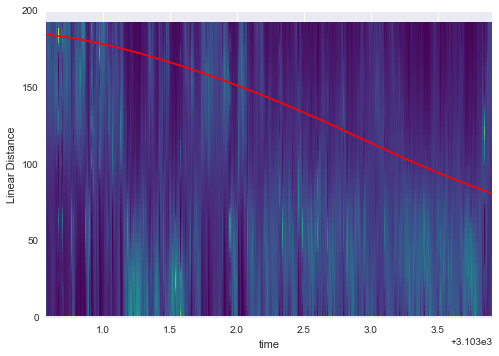

In [25]:
time = position_info[position_info.trial_number == 200].index.values
[time_grid, place_bins] = np.meshgrid(time, place_bin_centers)
plt.pcolormesh(time_grid, place_bins, posterior_density[0][0].T, cmap='viridis', vmin=0, vmax=0.1)
position_info[position_info.trial_number == 200].linear_distance.plot(color='red')
plt.ylabel('Linear Distance')